# Проект: "Модель предсказания оттока клиентов телекоммуникационной компании"

## Описание проекта
   Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператор собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Задача — обучить на этих данных модель для прогноза оттока клиентов.
## Техническое задание
   1. **Загрузка и знакомство с данными**
       - Загрузка данных try/except
       - Объединение датасетов
       - EDA (info, describe, визуализация распределений признаков)
       - Выводы по знакомству с данными
   2. **Предобработка данных**
       - Изучение пропусков в данных
       - Поиск аномали
       - Генерация признаков ( целевой признак достать из `end_date`, создать признак длительности подписки в днях)
   3. **Исследовательский анализ данных**
       - Рассмотреть числовые признаки в разрезе целевого
       - Рвссмотреть категориальные признаки в разрезе целевого
       - Удалить признаки не несущие смысля для модели
   4. **Подготовка к моделированию**
       - Разделение на выборки
       - Кодирование, масштабирование при необходимости
       - Корреляционный анализ
   5. **Обучение моделей** (минимум две)
       - Подбор моделей
       - Подбор гиперпараметров на кросс-валидации
       - Проверка качества лучшей модели
   6. **Исследование важности признаков лучшей моделе и их интерпритация**
   7. **Вывод**

# Все необходимые загрузки и импорты

In [1]:
!pip install shap -q
!pip install phik


[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import re
import phik

from phik.report import plot_correlation_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix
from lightgbm import LGBMClassifier
from time import time

sns.set()
RANDOM_STATE = 17062024
TEST_SIZE = 0.25
pd.set_option('display.max_colwidth', None)

# Все самописные функции

In [3]:
def camel_to_snake(names: list) -> list:
    '''
    Переводит значения списка записанные в CamelCase в snake_case
    '''
    snake_names = []
    for name in names:
        snake_name = re.sub(r'(?<!^)(?=[A-Z](?<![A-Z]{2}))', '_', name).lower()  # преобразование в snake_case
        snake_names.append(snake_name)
    return snake_names

In [4]:
def distributions_plot(df: pd.DataFrame,
                       col: str,
                       bins=30,
                       xlim=None,
                       ylim=None,
                       figsize=(15, 10),
                       title=None,
                       xlabel=None,
                       ylabel='Количество значений') -> None:
   
    '''
    Функция быстро строит графики распределений числовых значений. Имеет гибкую настройку
    отображения графиков.
    ''' 

    fig, ax = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.20, .80)}, figsize=figsize)

    if col in df.columns:
        sns.boxplot(x=df[col], 
                    ax=ax[0],
                    color='#8c8c8c')
        sns.histplot(df[col], 
                     ax=ax[1],
                     bins=bins,
                     color='#4f4d49',
                     edgecolor='black',
                     kde=True)
        if xlabel is None: 
            xlabel = col
            ax[0].set(xlabel='')
            ax[1].set(xlabel=xlabel, ylabel=ylabel, xlim=xlim, ylim=ylim)
            ax[1].grid(visible=True)
        
        if title == None:
            plt.suptitle(f'Распределение значений {col}', y=0.92, fontsize=14, fontweight='bold')
        else:    
            plt.suptitle(title, y=0.92, fontsize=14, fontweight='bold')
    else:
        print('Столбец', col, 'отсутсвует в датафрейме')

In [5]:
def boxplot_creator(df: pd.DataFrame,
                    parametr_x: str,
                    parametr_y: str,
                    title = None,
                    xlabel = None,
                    ylabel = None   
                   ) -> None:
    
    '''
    Функция принимает в качестве параметров датафрейм, параметр (название столбца)
    по которому будет строится ящик с усами, и строки с названием всего графика,
    оси Ox.
   
    На выходе функция не возвращает ничего. Функция строит ящик с усами по заданному параметру.
    '''
    
    sns.set()
    plt.figure(figsize=(8, 8))
    sns.boxplot(data=df,
                x=parametr_x,
                y=parametr_y,
                width=0.8,
    )
    
    if title != None:
        plt.title(title, fontsize=20, fontweight='bold')
    else:
        plt.title(f'Распределение значений {parametr_y} в разрезе целевого признака', fontsize=20, fontweight='bold')
    
    if xlabel != None:
        plt.xlabel(xlabel)
    else:
        plt.xlabel(parametr_x)
        
    if ylabel != None:
        plt.ylabel(ylabel)
    else:
        plt.ylabel(parametr_y)
    plt.show()

# Загрузка и знакомство с данными

In [6]:
try:
    contract_df = pd.read_csv('datasets/contract_new.csv')
except:
    contract_df = pd.read_csv('/datasets/contract_new.csv')
    
print("DataFrame size: ", contract_df.shape[0])   

contract_df.head()

DataFrame size:  7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [7]:
try:
    internet_df = pd.read_csv('datasets/internet_new.csv')
except:
    internet_df = pd.read_csv('/datasets/internet_new.csv')
    
print("DataFrame size: ", internet_df.shape[0])  

internet_df.head()

DataFrame size:  5517


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [8]:
try:
    personal_df = pd.read_csv('datasets/personal_new.csv')
except:
    personal_df = pd.read_csv('/datasets/personal_new.csv')
    
print("DataFrame size: ", personal_df.shape[0])    

personal_df.head()

DataFrame size:  7043


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
try:
    phone_df = pd.read_csv('datasets/phone_new.csv')
except:
    phone_df = pd.read_csv('/datasets/phone_new.csv')

print("DataFrame size: ", phone_df.shape[0])    

phone_df.head()

DataFrame size:  6361


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Так как все эти датафреймы это данные одной компании и в большом количестве случаев об одних и тех же ее клиентах, предлагаю объединить все датафреймы для дальнейшего удобства работы

In [10]:
data = (contract_df
        .merge(personal_df, on='customerID', how='left')
        .merge(phone_df, on='customerID', how='left')
        .merge(internet_df, on='customerID', how='left')   
       )

print("DataFrame size:", data.shape[0])
data.head()

DataFrame size: 7043


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,NaN,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,No,Fiber optic,No,No,No,No,No,No


Данные объеденены, теперь предлагаю записать все названия столбцов в snake_case (для удобства обращения к ним) и рассмотреть общую информацию о данных

In [11]:
data.columns = camel_to_snake(data.columns)

In [12]:
contract_cols = camel_to_snake(contract_df.columns)
internet_cols = camel_to_snake(internet_df.columns)
personal_cols = camel_to_snake(personal_df.columns)
phone_cols = camel_to_snake(phone_df.columns)

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
 8   gender             7043 non-null   object 
 9   senior_citizen     7043 non-null   int64  
 10  partner            7043 non-null   object 
 11  dependents         7043 non-null   object 
 12  multiple_lines     6361 non-null   object 
 13  internet_service   5517 non-null   object 
 14  online_security    5517 non-null   object 
 15  online_backup      5517 non-null   object 
 16  device_protection  5517 

Сразу изменим неправильные типы данных:
   - BeginDate переведем в datetime
   - EndDate переведем в datetime
   - TotalCharges переведем в float
   - Поменяем типы данных категориальных столбцов на category ( на этапе предобработке, чтобы беспроблемно заполнить пропуски)

In [13]:
data['begin_date'] = pd.to_datetime(data['begin_date'])
data['end_date'] = pd.to_datetime(data['end_date'], errors='coerce')

Столбец TotalCharges содержит посторонние значеня, которые мешают преобразованию типов, найдем их и подумаем, что можно с ними сделать.

In [14]:
sorted(data['total_charges'].unique())[:5]

[' ', '100.17', '100.19', '100.2', '100.24']

In [15]:
data[data['total_charges'] == ' ']

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
488,4472-LVYGI,2020-02-01,NaT,Two year,Yes,Bank transfer (automatic),52.55,,Female,0,Yes,Yes,NaN,DSL,Yes,No,Yes,Yes,Yes,No
753,3115-CZMZD,2020-02-01,NaT,Two year,No,Mailed check,20.25,,Male,0,No,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
936,5709-LVOEQ,2020-02-01,NaT,Two year,No,Mailed check,80.85,,Female,0,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes
1082,4367-NUYAO,2020-02-01,NaT,Two year,No,Mailed check,25.75,,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1340,1371-DWPAZ,2020-02-01,NaT,Two year,No,Credit card (automatic),56.05,,Female,0,Yes,Yes,NaN,DSL,Yes,Yes,Yes,Yes,Yes,No
3331,7644-OMVMY,2020-02-01,NaT,Two year,No,Mailed check,19.85,,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3826,3213-VVOLG,2020-02-01,NaT,Two year,No,Mailed check,25.35,,Male,0,Yes,Yes,Yes,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4380,2520-SGTTA,2020-02-01,NaT,Two year,No,Mailed check,20.00,,Female,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5218,2923-ARZLG,2020-02-01,NaT,One year,Yes,Mailed check,19.70,,Male,0,Yes,Yes,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6670,4075-WKNIU,2020-02-01,NaT,Two year,No,Mailed check,73.35,,Female,0,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No


У всех клиентов с пропусками в столбце total_charges видна важная зависимость - это новые клиенты. Так как данные актуальны на 1 февраля 2020 года. Значит из общее число денег пренесенных компании равно их месячной плате. Так и заполним.

In [16]:
data['total_charges'].replace(' ', pd.NA, inplace=True)
data['total_charges'].fillna(data['monthly_charges'], inplace=True)
data['total_charges'].isna().sum()

0

Отлично, в этом столбце мы избавились от пропусков. Приведем total_charges к числовому виду.

In [17]:
data['total_charges'] = pd.to_numeric(data['total_charges'])

Сохраним названия категориальных столбцов

In [18]:
data['senior_citizen'] = data['senior_citizen'].apply(lambda x: 'Yes' if x == 1 else 'No')
cat_cols = list(data.select_dtypes('object').columns)
cat_cols.remove('customer_id')
print(cat_cols)

['type', 'paperless_billing', 'payment_method', 'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']


In [19]:
data.dtypes

customer_id                  object
begin_date           datetime64[ns]
end_date             datetime64[ns]
type                         object
paperless_billing            object
payment_method               object
monthly_charges             float64
total_charges               float64
gender                       object
senior_citizen               object
partner                      object
dependents                   object
multiple_lines               object
internet_service             object
online_security              object
online_backup                object
device_protection            object
tech_support                 object
streaming_tv                 object
streaming_movies             object
dtype: object

Все типы данных приведены к нужным, теперь необходимо рассмотреть распределение признаков. Начнем с числовых признаков.

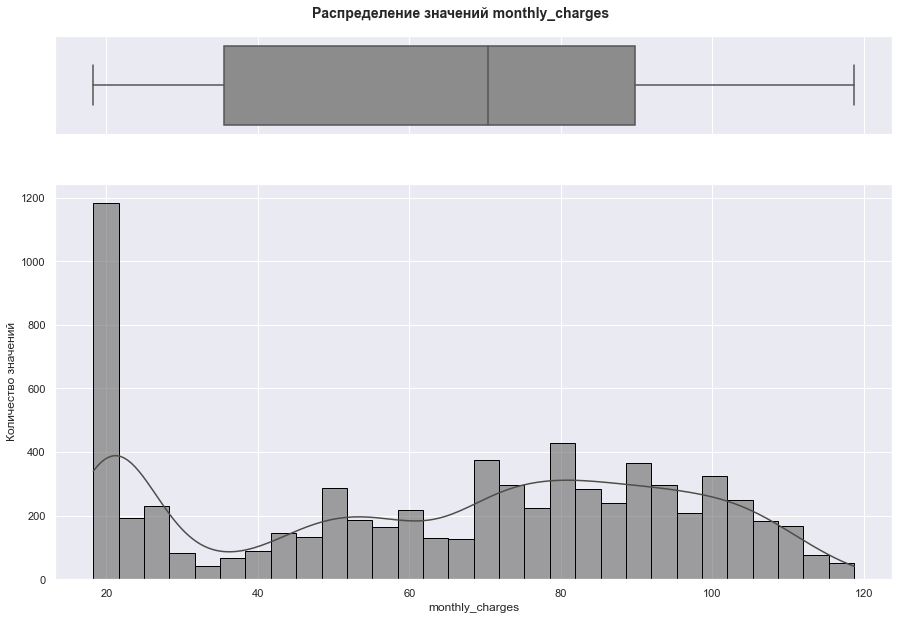

In [20]:
distributions_plot(data, 'monthly_charges')

Выбросов в этих значениях нет, но распределены они не нормально. Больше всего значений находится в райней 20-ти долларов, это легко объяснить тем, что большинству пользователей не нужны дорогостоющие услуги от провайдера, так что с этим столбцом никаких проблем нет.

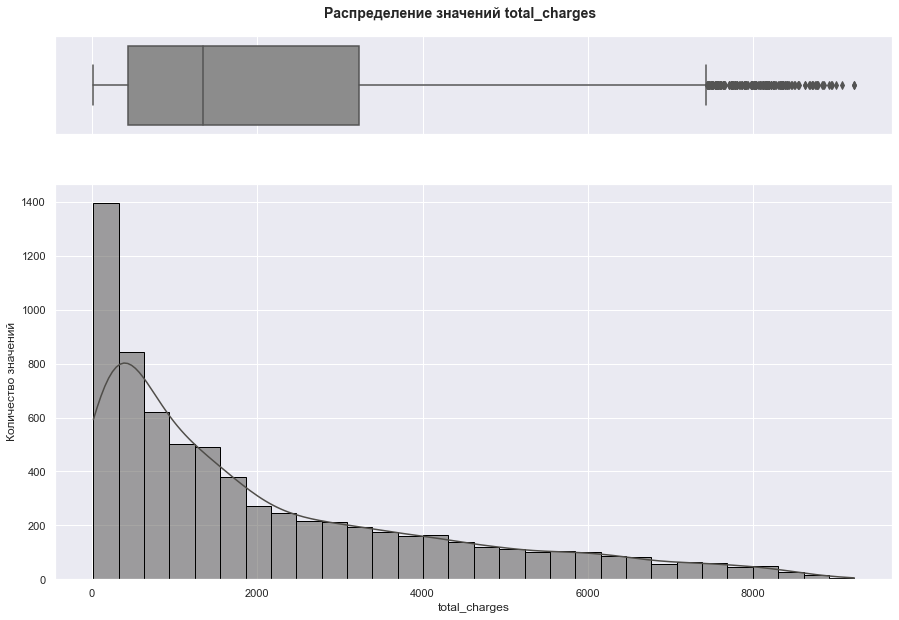

In [21]:
distributions_plot(data, 'total_charges')

Судя по ящику с усами данный признак обладает большим количеством выбросов, на гистограмме распределения так же виден длинный хвост из больших значений, но так как из много мы не можем их удалить по двум причинам: 1) эти значения помогут понять, как часто уходят клиенты, которые потратили много денег за время работы с данным оператором 2) данных у нас и так немного и нужно пытаться максимально сократить количество удалений

Рассмотрим распределение категориальных признаков

In [22]:
for col in cat_cols:
    print(f'Распределение значений в столбце {col}:')
    display(data[col].value_counts())
    print('\n ================================')

Распределение значений в столбце type:


Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64


Распределение значений в столбце paperless_billing:


Yes    4171
No     2872
Name: paperless_billing, dtype: int64


Распределение значений в столбце payment_method:


Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64


Распределение значений в столбце gender:


Male      3555
Female    3488
Name: gender, dtype: int64


Распределение значений в столбце senior_citizen:


No     5901
Yes    1142
Name: senior_citizen, dtype: int64


Распределение значений в столбце partner:


No     3641
Yes    3402
Name: partner, dtype: int64


Распределение значений в столбце dependents:


No     4933
Yes    2110
Name: dependents, dtype: int64


Распределение значений в столбце multiple_lines:


No     3390
Yes    2971
Name: multiple_lines, dtype: int64


Распределение значений в столбце internet_service:


Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64


Распределение значений в столбце online_security:


No     3498
Yes    2019
Name: online_security, dtype: int64


Распределение значений в столбце online_backup:


No     3088
Yes    2429
Name: online_backup, dtype: int64


Распределение значений в столбце device_protection:


No     3095
Yes    2422
Name: device_protection, dtype: int64


Распределение значений в столбце tech_support:


No     3473
Yes    2044
Name: tech_support, dtype: int64


Распределение значений в столбце streaming_tv:


No     2810
Yes    2707
Name: streaming_tv, dtype: int64


Распределение значений в столбце streaming_movies:


No     2785
Yes    2732
Name: streaming_movies, dtype: int64



Краткий обзор распределений в столбцах:
   - Самым популярным типом оплаты является месячный платеж, ежегодный платеж наименее популяерен
   - Большинство пользователей требуют электронный расчетный лист
   - Наиболее поплуярной формой оплаты является электронный чек, наименее популярны автоплатежи
   - По гендерной принадлежности пользователи распределены почти одинаково
   - Пользователей находящихся в браке примерно столько же сколько и одиноких
   - У большинства пользователей нет детей
   - У большинства пользователей телефон подключен к одной линии
   - У большинства пользователей интернет подключен при помощи оптоволокна
   - У большинства пользователей отключина блокировка опасных сайтов
   - У большинства пользователей отключено облачное хранилище файлов для резервного копирования данных
   - У большинства пользователей отключен антивирус
   - Для большинства пользователей нет выделенной линии технической поддержки
   - Количество пользователей с подключенным стримминговым телевидинием почти равно количеству пользователей с отключенным стримминговым ТВ
   - Аналогичная ситуация с каталогом фильмов
   - Большинство пользователей не являются пенсионерами
   
Важно уточнить, что общее количество значений зависит от размера изначального датасета, забегая вперед можно сказать, что пропуски в данных скорее всего обусловлены тем, что датасеты распределены по услугам интернет и телефония, поэтому у какие-то пользователи могут использовать только телефонию, а какие-то только интернет от данного провайдера.

## Вывод по первичному анализу данных
   - На этапе первичного анализа все исходные датафреймы были объеденены в один
   - Были откорректированы типы значений (даты, вещественные числа, категории). На этом этапе обаружилось 11 значений с пустой строкой в столпце total_charges, которые были вызваны появлением новых пользователей. Эти значения были заменены на их месячную плату, так как на данный момент она является для них полной.
   - Были изучены их распределения всех признаков, выбросов выявлено небыло

# Предобработка данных
## Работа с выбросами
Еще раз рассмотрим распределение столбца `total_charges` так как на его графике был виден хвост из значений, рассмотри его подробнее

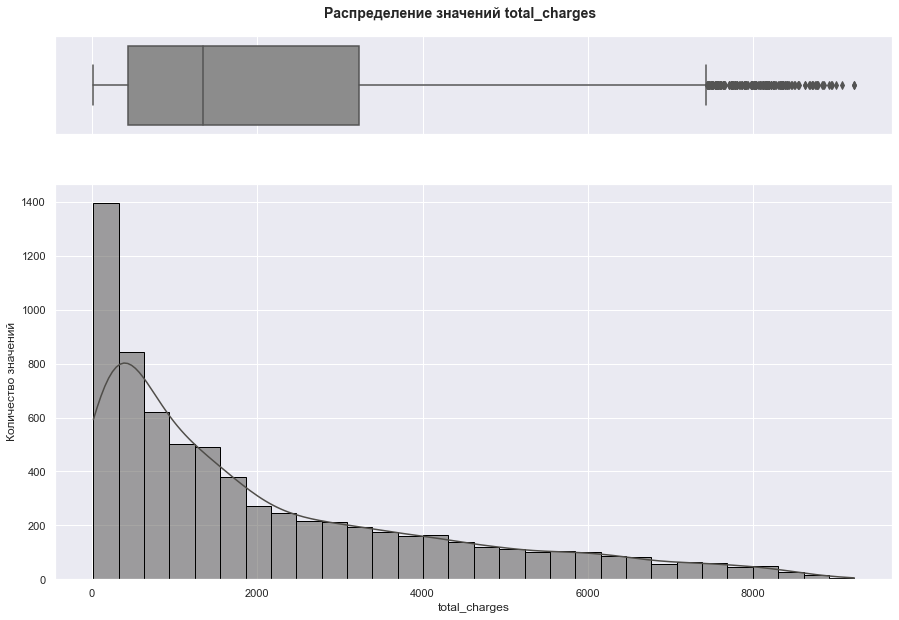

In [23]:
distributions_plot(data, 'total_charges')

In [24]:
boxplot = plt.boxplot(data['total_charges'].values);
outliers = boxplot['fliers'][0].get_data()[1]
df_outliers = data[data["total_charges"].isin(outliers)]
print("Количество аномалий: ", len(df_outliers))

plt.close()

Количество аномалий:  195


Я считаю, что аномалий достаточно много и их удаление может привести к ухудшению качества модели, так же я считаю что удалить их нельзя, чтобы модель могла предсказывать как часто компанию покидают пользователеи которые уже внесли в ее бюджет много средств.

## Работа с пропусками и генерация признаков

In [25]:
data.isna().sum()

customer_id             0
begin_date              0
end_date             5942
type                    0
paperless_billing       0
payment_method          0
monthly_charges         0
total_charges           0
gender                  0
senior_citizen          0
partner                 0
dependents              0
multiple_lines        682
internet_service     1526
online_security      1526
online_backup        1526
device_protection    1526
tech_support         1526
streaming_tv         1526
streaming_movies     1526
dtype: int64

Больше всего пропусков в столбце с датой окончания договора, но это хорошо, этот столбец нам пригодится только для генерации целевой переменной и нового признака - **длительность подписки**, для обучения модели этот признак не подойдет так как приведет к утечек данных. Пропуски в нем мы исправим на этапе предобработки данных.

Остальные пропуски в данных обусловлены тем, что датасеты распределены по услугам интернет и телефония, поэтому какие-то пользователи могут использовать только телефонию, а какие-то только интернет от данного провайдера. Поэтому все пропуски кроме пропусков в столбце end_date заменим на занчение No, так как другие адекватные значения подобрать мы не можем.

Но сначала сгенерируем целевой признак так, что 0 - обозначает, что пользователь все еще пользуется услугами компании и 1 - пользователь перестал пользоваться услугами, и новый признак **длительность подписки**

In [26]:
data['target'] = data['end_date'].apply(lambda x: 0 if pd.isna(x) else 1)

Для того, чтобы узнать длительность подписки всех пользователей, найдем максимальную дату окончания подписки и будем использовать ее, но прибавим к ней один месяц, как крайнюю дату и для оставшихся пользователей, чтобы пользователи которые подписались в прошлом месяце не отображались как люди с 0 дней подписки

In [27]:
max_date = data['end_date'].max() + pd.DateOffset(months=1)
data['end_date_filled'] = data['end_date'].fillna(max_date)
data['duration_days'] = (data['end_date_filled'] - data['begin_date']).dt.days

data.head()

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,...,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,end_date_filled,duration_days
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,...,DSL,No,Yes,No,No,No,No,0,2020-02-01,31
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,2071.84,Male,No,...,DSL,Yes,No,Yes,No,No,No,0,2020-02-01,1036
2,3668-QPYBK,2019-10-01,NaT,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,...,DSL,Yes,Yes,No,No,No,No,0,2020-02-01,123
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,...,DSL,Yes,No,Yes,Yes,No,No,0,2020-02-01,1371
4,9237-HQITU,2019-09-01,NaT,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,...,Fiber optic,No,No,No,No,No,No,0,2020-02-01,153


Теперь можем удалить столбцы `begin_date`, `end_date`, и `end_date_filled`

In [28]:
data.drop(['begin_date', 'end_date', 'end_date_filled'], axis=1, inplace=True)
data.head()

,customer_id,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,duration_days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,NaN,DSL,No,Yes,No,No,No,No,0,31
1,5575-GNVDE,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No,0,123
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,NaN,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No,0,153


Теперь заменим все остальные пропуски в данных значениями No с названием отсутсвующей категориии и заменим тип категориальных значений на category

In [29]:
for col in phone_cols:
    data[col] = data[col].fillna('No phone')
    
for col in internet_cols:
    data[col] = data[col].fillna('No internet')
    
data.isna().sum()

customer_id          0
type                 0
paperless_billing    0
payment_method       0
monthly_charges      0
total_charges        0
gender               0
senior_citizen       0
partner              0
dependents           0
multiple_lines       0
internet_service     0
online_security      0
online_backup        0
device_protection    0
tech_support         0
streaming_tv         0
streaming_movies     0
target               0
duration_days        0
dtype: int64

In [30]:
data[cat_cols] = data[cat_cols].astype('category')

In [31]:
data.dtypes

customer_id            object
type                 category
paperless_billing    category
payment_method       category
monthly_charges       float64
total_charges         float64
gender               category
senior_citizen       category
partner              category
dependents           category
multiple_lines       category
internet_service     category
online_security      category
online_backup        category
device_protection    category
tech_support         category
streaming_tv         category
streaming_movies     category
target                  int64
duration_days           int64
dtype: object

Так же для модели не имеет смысла значение признак `customer_id`, поэтому мы можем удалить его

In [32]:
data.drop('customer_id', axis=1, inplace=True)
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,duration_days
0,Month-to-month,Yes,Electronic check,29.85,31.04,Female,No,Yes,No,No phone,DSL,No,Yes,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,Male,No,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,Male,No,No,No,No,DSL,Yes,Yes,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,Male,No,No,No,No phone,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,Female,No,No,No,No,Fiber optic,No,No,No,No,No,No,0,153


## Вывод по предобработке данных

- На этапе предобработки данных были более подробно изучены выбосы в одном из числовых столбцов и было принято решение оставить это, так как это скорее не выбросы, а хвост из значений которые должны помочь обучить моедль
- Были сгенерированны признаки, во-первых целевой признак `target` он равен 0, если пользователь все еще пользуется услугами компании и 1, если пользователь разорвал договоры с компанией. Так же был сгенирирован признак `duration` - продолжительность подписки на сервисы компании в днях. Он рассчитывается как **дата конца подписки** минус **дата начала подписки**, если есть дата окончания, если нет, то **дата конца подписки плюс один месяц** минус **дата начала подписки** чтобы модель отличала новых пользователей и не присваивала им 0 дней работы с компанией, так как жто может плохо сказаться на качетсве моделирования?
- Все пропуски в данных были заменены, так как пропуски возникили, потому что некоторые пользователи пользуются чем то одним, напиример только интернетом или только телефонией

# Исследовательский анализ данных

## Непрерывные величины отосительно целевого признака

In [33]:
num_cols = list(data.select_dtypes(include='number').columns)
num_cols.remove('target')

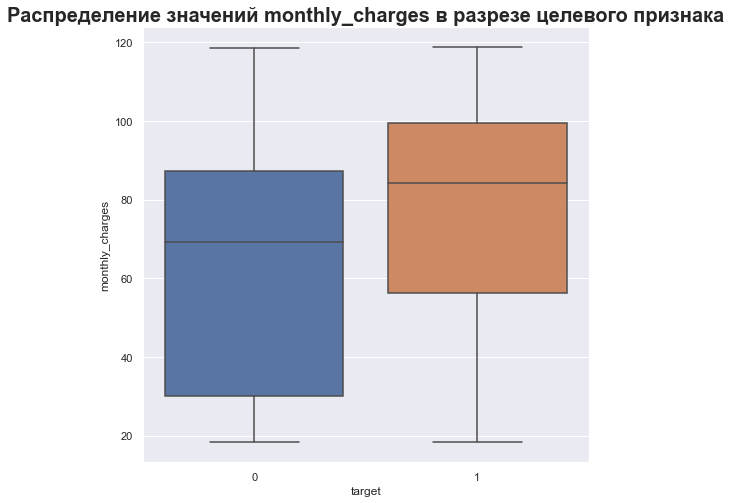

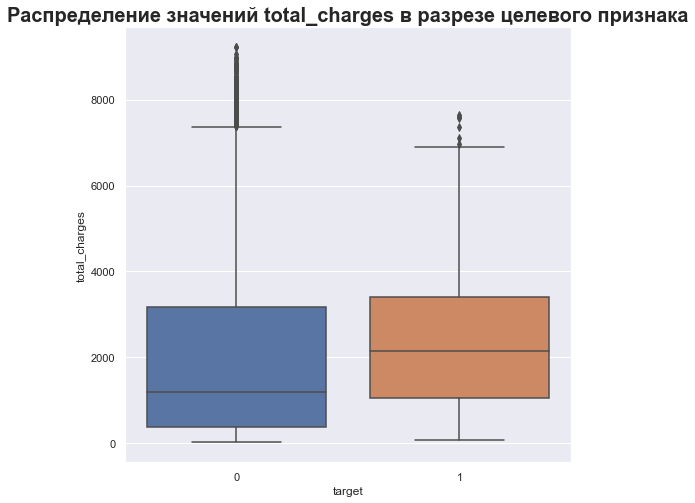

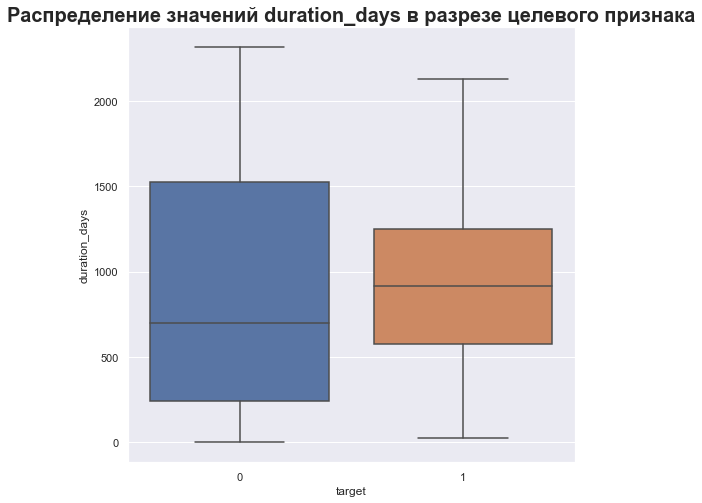

In [34]:
for num_col in num_cols:
    boxplot_creator(data, 'target', num_col)

### Вывод по анализу непрерывных вличин

У всех непрерывных значений в разрезе целевого признака наблюдается странная закономерность - у людей разорвавших договр с компание все значения выше т.е. : чем больше пользователь платит за услугу тем больше вероятность того, что он разрввет контракт, так же, чем дольше пользователь пользуется услугами компании тем больше шанс, что он разорвет с ней контракт

## Категориальные признаки относительно целевого

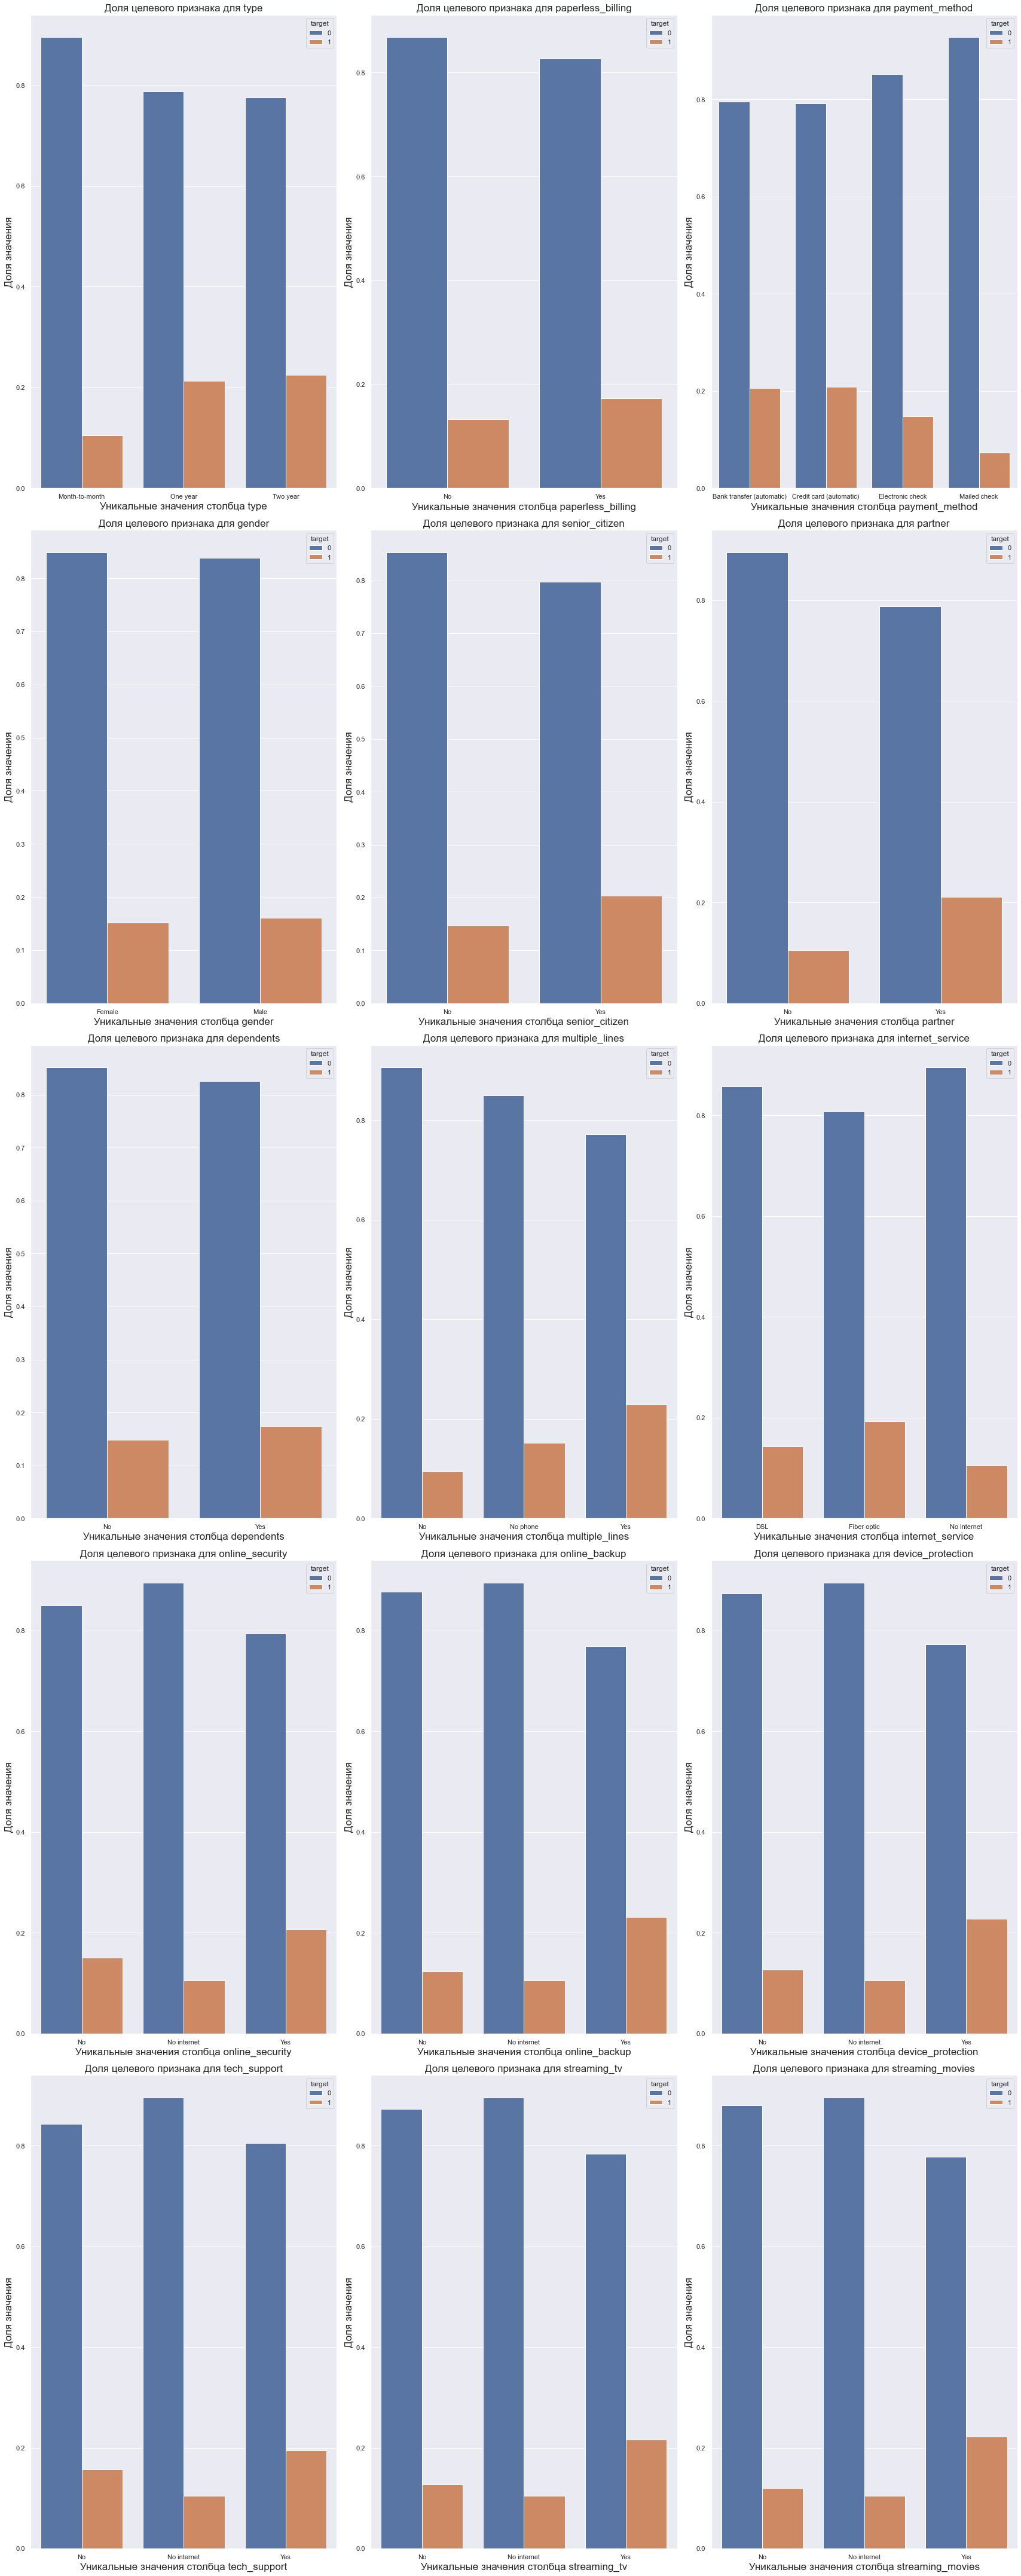

In [35]:
rows = 5
cols = 3

fig, axs = plt.subplots(rows, cols, figsize=(12, 30))

# Проход по уникальным значениям и создание графиков
for i, value in enumerate(cat_cols):
    row = i // cols
    col = i % cols
    ax = axs[row, col]

    # Фильтрация данных для текущего уникального значения
    normalized_counts = data.groupby(value)['target'].value_counts(normalize=True).unstack(fill_value=0).reset_index()
    melted_data = normalized_counts.melt(id_vars=value, var_name='target', value_name='Доля')

    sns.barplot(x=value, y='Доля', hue='target', data=melted_data, ax=ax)

    ax.set_title(f'Доля целевого признака для {value}', fontsize=17)
    ax.set_xlabel(f'Уникальные значения столбца {value}', fontsize=17)
    ax.set_ylabel('Доля значения', fontsize=17)

plt.tight_layout(rect=[0, 0, 2, 2])
plt.show()

### Вывод по исследовательскому анализу категориальных признаков

На этих данных можно заметить интересные тенденции:
   - Пользователи с годовой и двух довой подпиской чаще расторгают контракт
   - Пользователи которые пользуются какимилибо услугами компании чаще расторгают с ней контракт
   
Так же можно обнаружить некоторые столбцы, которые скорее всего окажутся бесполезными для работы модели:
   - Гендер скорее всего вообще никак не влияет на желание пользоваться услугами компании (gender)
   - Также почти никакого влияния не оказывает факт наличия или отсутсвия детей у абонента (dependents)
Предлагаю удалить эти столбцы, такак скорее всего они будут только мешать делать модели предсказания

In [36]:
data = data.drop(['gender', 'dependents'], axis=1)
data.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,target,duration_days
0,Month-to-month,Yes,Electronic check,29.85,31.04,No,Yes,No phone,DSL,No,Yes,No,No,No,No,0,31
1,One year,No,Mailed check,56.95,2071.84,No,No,No,DSL,Yes,No,Yes,No,No,No,0,1036
2,Month-to-month,Yes,Mailed check,53.85,226.17,No,No,No,DSL,Yes,Yes,No,No,No,No,0,123
3,One year,No,Bank transfer (automatic),42.30,1960.60,No,No,No phone,DSL,Yes,No,Yes,Yes,No,No,0,1371
4,Month-to-month,Yes,Electronic check,70.70,353.50,No,No,No,Fiber optic,No,No,No,No,No,No,0,153


# Подготовка к моделированию
## Корреляционный анализ
Я не планирую использовать линейные модели, так как у нас большое количество категориальных данных и мне кажется что они могут справиться плохо, но постмотреть матрицу корреляции все равно считаю необходимым

In [37]:
cat_cols = list(data.select_dtypes('category').columns)
cat_cols
data.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'senior_citizen', 'partner', 'multiple_lines',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'target', 'duration_days'],
      dtype='object')

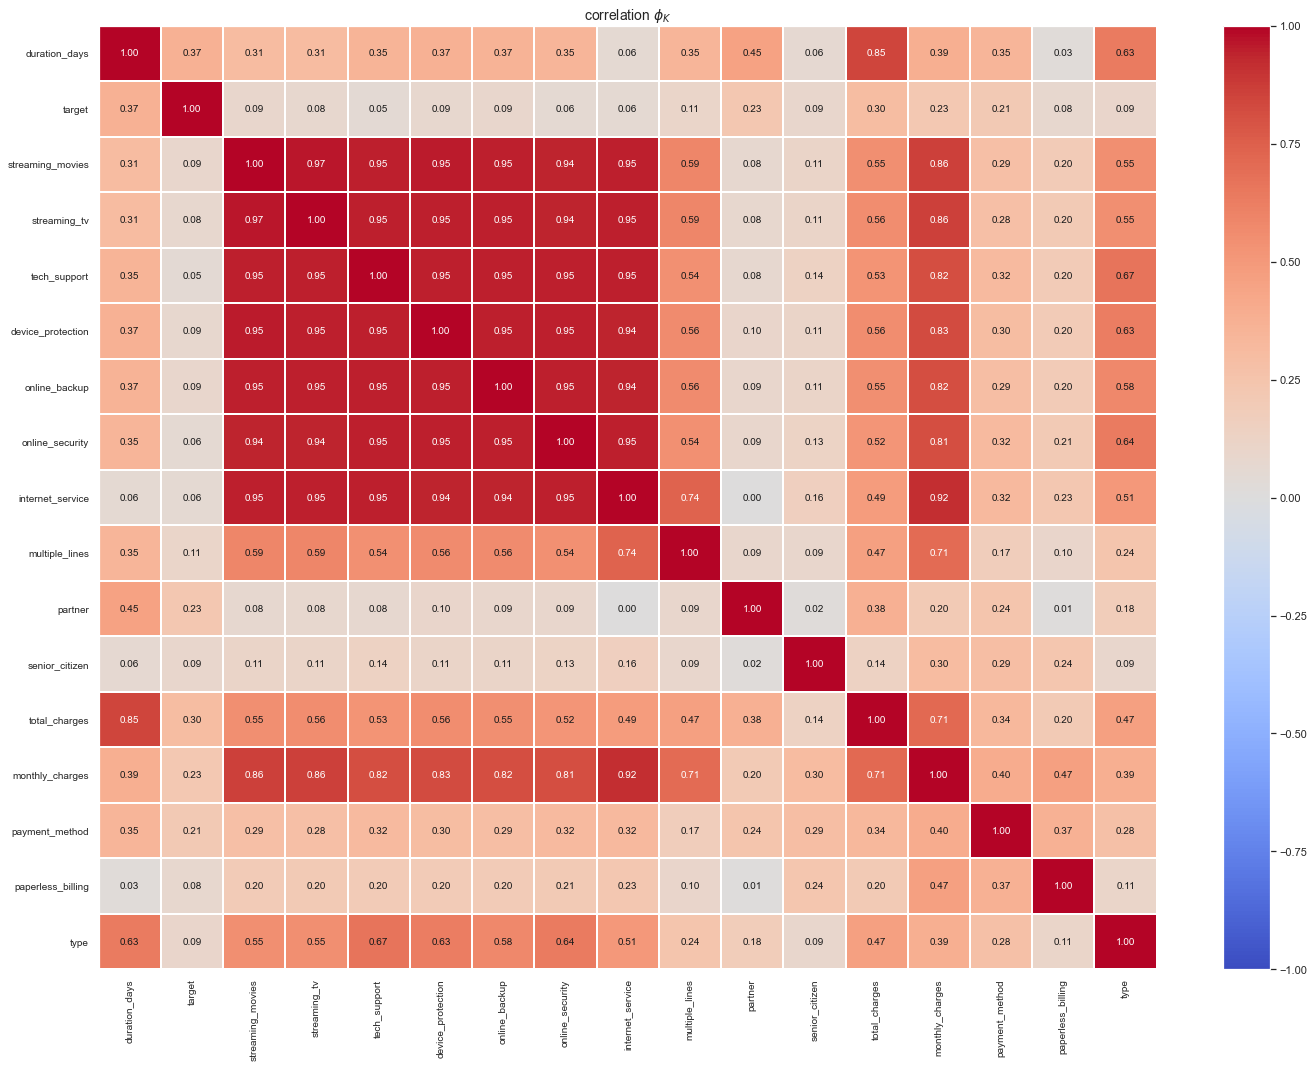

In [38]:
int_cols = ['monthly_charges', 'total_charges', 'duration_days']

phik_overview = data.phik_matrix(interval_cols=int_cols)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r'correlation $\phi_K$',
    color_map='coolwarm',
    figsize=(20, 15)
) 

Сильнее всего целевая переменная зависит от значения в параметре `duration_days`, но этот признак не дает утечки данных. В данных есть мультиколлениарность, но она нас не инnересует, так как я планирую испльзовать модели на основе деревьев, а они не сильно воспреимчивы к мультиколлениарности.

## Разделение на выборки

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target'], axis=1),
    data['target'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = data['target']
)

X_train.head()

,type,paperless_billing,payment_method,monthly_charges,total_charges,senior_citizen,partner,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,duration_days
721,Two year,No,Credit card (automatic),20.55,1341.30,No,Yes,No,No internet,No internet,No internet,No internet,No internet,No internet,No internet,1857
3922,Month-to-month,Yes,Credit card (automatic),94.65,6341.55,Yes,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,2041
6497,Month-to-month,Yes,Electronic check,103.05,5358.60,No,No,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,1584
4784,Month-to-month,Yes,Mailed check,19.55,20.53,No,No,No,No internet,No internet,No internet,No internet,No internet,No internet,No internet,31
2980,Two year,No,Credit card (automatic),25.45,293.95,No,No,Yes,No internet,No internet,No internet,No internet,No internet,No internet,No internet,334


Так как планируется использовать модели основанные на решающих деревьях, категориальные данные нужно закадировать в OrdinalEncoder, чтобы таблица не размножала признаки и не росла в ширь, а численные данные можно никак не масштабировать. Пострим пайплайн для обучения моделей.

# Моделирование
## Создание пайплайна для моделей на решающих деревьях

In [40]:
num_cols = ['monthly_charges', 'total_charges', 'duration_days']


ord_pipe = Pipeline(
    [
     ('ord', OrdinalEncoder())
    ]
)

data_preprocessor = ColumnTransformer(
    [
     ('ord', ord_pipe, cat_cols),
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])


In [41]:
param_grid_tree= [
    {
        'models' : [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth' : range(2, 15),
        'models__max_features' : range(2, 15),
        'models__min_samples_split' : range(2, 15)
    }
]

param_grid_forest = [
    {
        'models' : [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators' : range(2, 100),
        'models__max_depth' : range(2, 10),
        'models__min_samples_leaf' : range(2, 10),
        'models__max_features' : range(2, 10),
        'models__max_leaf_nodes' : range(2, 100)
    }
]

### Обучение моделей

In [42]:
grid_tree = RandomizedSearchCV(
    pipe_final,
    param_grid_tree, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise',
    n_iter=100,
    random_state=RANDOM_STATE
)
grid_tree.fit(X_train, y_train)

print(f'Метрика ROC-AUC лучшей модели DecisionTreeClassifier на кросс-валидации равна {round(grid_tree.best_score_, 4)}')
print('Лучшая модель и ее гиперпараметры: \n', grid_tree.best_estimator_)

Метрика ROC-AUC лучшей модели DecisionTreeClassifier на кросс-валидации равна 0.7877
Лучшая модель и ее гиперпараметры: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_

Метрика лучшей модели DecisionTreeClassifier на кросс валидации слишком маленькая

In [43]:
grid_forest = RandomizedSearchCV(
    pipe_final,
    param_grid_forest, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    error_score='raise',
    n_iter=100,
    random_state=RANDOM_STATE
)
grid_forest.fit(X_train, y_train)

print(f'Метрика ROC-AUC лучшей модели RandomForestClassifier на кросс-валидации равна {round(grid_forest.best_score_, 4)}')
print('Лучшая модель и ее гиперпараметры: \n', grid_forest.best_estimator_)

Метрика ROC-AUC лучшей модели RandomForestClassifier на кросс-валидации равна 0.8307
Лучшая модель и ее гиперпараметры: 
 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder())]),
                                                  ['type', 'paperless_billing',
                                                   'payment_method',
                                                   'senior_citizen', 'partner',
                                                   'multiple_lines',
                                                   'internet_service',
                                                   'online_security',
                                                   'online_backup',
                                                   'device_

Метрики модели RandomForestClassifier тоже не хватает для решения поставленной задачи. Поэтому считаю нужным использовать модель градиентного бустинга.

## Бустинг

Будем использовать модель LGBMClassifier, подбор гиперпараметров проведем с помощью GridSearchCV. Разделим данные на трейн и тест, и преобразуем их в специальный формат данных для этой модели.

In [44]:
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

In [45]:
params_lgbmc = {
    'learning_rate': [0.0005, 0.001, 0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300, 500],
    'num_leaves': [31, 71, 101, 151],
    'class_weight': [None, 'balanced']
}

grid_lgbm = GridSearchCV(
    LGBMClassifier(random_state=RANDOM_STATE, metric='auc'),
    params_lgbmc,
    scoring='roc_auc',
    return_train_score=True,
    cv=5
)

grid_lgbm.fit(train_data.data, train_data.label)

print(f'Метрика ROC-AUC лучшей модели RandomForestClassifier на кросс-валидации равна {round(grid_lgbm.best_score_, 4)}')
print('Лучшая модель и ее гиперпараметры: \n', grid_lgbm.best_estimator_)

Метрика ROC-AUC лучшей модели RandomForestClassifier на кросс-валидации равна 0.878
Лучшая модель и ее гиперпараметры: 
 LGBMClassifier(learning_rate=0.05, metric='auc', n_estimators=500,
               random_state=17062024)


## Запуск лучшей модели на тестовых данных

In [46]:
model = grid_lgbm.best_estimator_

In [47]:
start = time()
model.fit(train_data.data, train_data.label)
end = time()
model_fit_time = round(end - start, 2)
print(f'Время обучения лучшей выбранной модели - {model_fit_time}')

Время обучения лучшей выбранной модели - 0.78


In [48]:
start = time()
prediction = model.predict(test_data.data)
end = time()
model_predict_time = round(end - start, 2)
print(f'Время предсказания лучшей выбранной модели - {model_predict_time}')


pred_proba = model.predict_proba(test_data.data)[:,1]

Время предсказания лучшей выбранной модели - 0.07


In [49]:
test_metric = round(roc_auc_score(test_data.label, pred_proba), 4)
print(f'Метрика ROC-AUC на тестовых данных - {test_metric}')

Метрика ROC-AUC на тестовых данных - 0.8908


Метрика на тестовых данных удовлетворяет условию задачи и впринципе показывает неплохой резлультат. Можно перезодить к анализу модели. 

# Анализ лучшей модели

## Анализ важности признаков

,feature,gain
15,duration_days,5158
3,monthly_charges,3256
4,total_charges,2972
0,type,616
7,multiple_lines,355
6,partner,342
9,online_security,331
10,online_backup,288
11,device_protection,281
14,streaming_movies,280


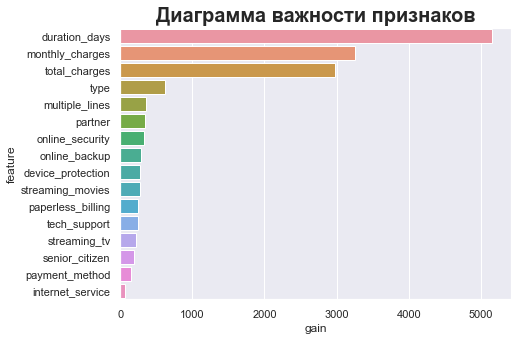

In [50]:
gain_importance = model.feature_importances_
feature_names = model.feature_name_
gain_importance_df = pd.DataFrame({'feature': feature_names, 'gain': gain_importance})
display(gain_importance_df.sort_values(by='gain', ascending=False))
plt.figure(figsize=(7, 5))
sns.barplot(data=gain_importance_df.sort_values(by='gain', ascending=False),
            x='gain',
            y='feature')
plt.title('Диаграмма важности признаков',
          fontsize=20,
          fontweight='bold')  
plt.show()

Самым важным признаком нашей модели оказался признак -  duration_days (продолжительность пользования услугами в днях). Так же очень важными для модели являются признаки: monthly_charges (размер месечной платы) и total_charges (общая сумма выплат).

Остальные признаки были намного менее важны для модели и их значимость примерно одинаковая.

## ROC-кривая

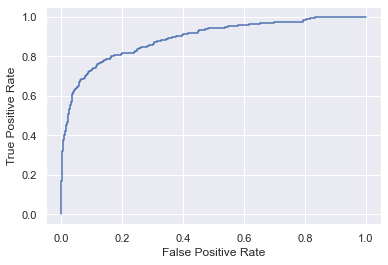

In [51]:
fpr, tpr, _ = roc_curve(test_data.label,  pred_proba)

plt.plot(fpr, tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

ROC-кривая возрастает не очень резко, это говорит о том, что моедель предсказывает данные не совсем точно. Но наша метрика и кривая так же говорит нам о том, что модель не переобучена и, что в среднем ее предсказания достаточно точные для данной задачи. Рассмотри как модедль предсказывает отдельные классы пользователей при помощи матрици ошибок.

## Матрица ошибок и оценка accuracy

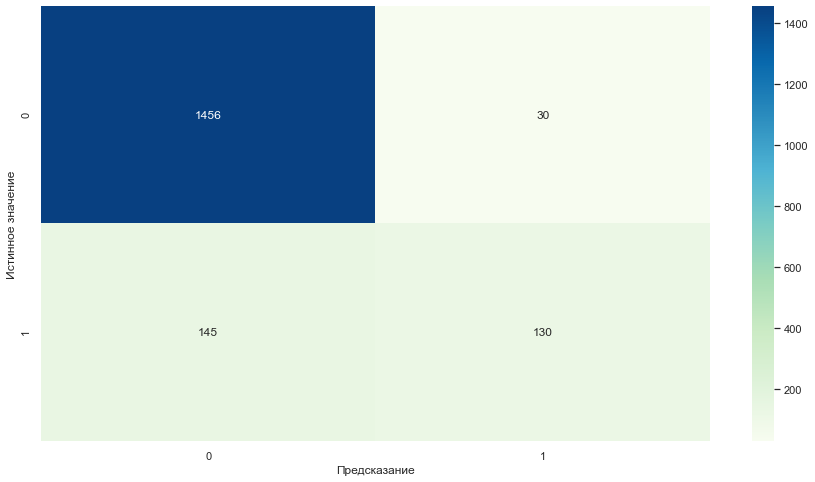

In [52]:
cm = confusion_matrix(test_data.label, model.predict(test_data.data))
sns.set()
plt.figure(figsize=(15,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='GnBu')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказание');

In [53]:
print(f'accuracy = {round(accuracy_score(test_data.label, model.predict(test_data.data)), 4)}')

accuracy = 0.9006


По полученным данным можно сказать, что наша модель хорошо справляется с поставленной задачей, потому что в матрице ошбок мало ложно-положительных и ложно-отрицательных значений - это хороший результат. Дисбаланс классов имеет небольшое влияние на модель модель чаще выдает ложноотрицательные значения.

Метрика accuracy равная 0.9006 - означает, что общая предсказательная способность модели находится на высоком уровне.

# Вывод по проделаной работе

1. **Загрузка и знакомство с данными**
      - На этапе первичного анализа все исходные датафреймы были объеденены в один
      - Были откорректированы типы значений (даты, вещественные числа, категории). На этом этапе обаружилось 11 значений с пустой строкой, которые было невозможно корректно заменить и их пришлось удалить
      - Были изучены их распределения всех признаков, выбросов выявлено небыло
2. **Предобработка данных**
      - На этапе предобработки данных были более подробно изучены выбосы в одном из числовых столбцов и было принято решение оставить это, так как это скорее не выбросы, а хвост из значений которые должны помочь обучить моедль
      - Были сгенерированны признаки, во-первых целевой признак `target` он равен 0, если пользователь все еще пользуется услугами компании и 1, если пользователь разорвал договоры с компанией. Так же был сгенирирован признак `duration` 
      - продолжительность подписки на сервисы компании в днях. Он рассчитывается как **дата конца подписки** минус **дата начала подписки**, если есть дата окончания, если нет, то **дата конца подписки плюс один месяц** минус **дата начала подписки** чтобы модель отличала новых пользователей и не присваивала им 0 дней работы с компанией, так как жто может плохо сказаться на качетсве моделирования?
      - Все пропуски в данных были заменены, так как пропуски возникили, потому что некоторые пользователи пользуются чем то одним, напиример только интернетом или только телефонией
3. **Исследовательский анализ данных**
     - На этапе исследовательского анализа был проведен анализ непрерывных и категориальных признаков в разрезе целевого
     - Анализ непрерывных признаков в разрезе целевого:
         - У всех непрерывных значений в разрезе целевого признака наблюдается странная закономерность - у людей разорвавших договр с компание все значения выше т.е. : чем больше пользователь платит за услугу тем больше вероятность того, что он разрввет контракт, так же, чем дольше пользователь пользуется услугами компании тем больше шанс, что он разорвет с ней контракт
     - Анализ категориальных признаков в разрезе целевого:
         - На этих данных можно заметить интересные тенденции:
           - Пользователи с годовой и двух довой подпиской чаще расторгают контракт
           - Пользователи которые пользуются какимилибо услугами компании чаще расторгают с ней контракт
   
         - Так же можно обнаружить некоторые столбцы, которые скорее всего окажутся бесполезными для работы модели:
              - Гендер скорее всего вообще никак не влияет на желание пользоваться услугами компании (gender)
              - Также почти никакого влияния не оказывает факт наличия или отсутсвия детей у абонента (dependents)
         - Эти признаки были удалены
4. **Подготовка к моделированию**
      - Была рассмотрена матрица корреляции - в данных есть мультиколлениарность, но это не важно так как в проекте используются модели на основе деревье
      - На этом этапе данные были разделены на обучающую и тестовую выборку
5. **Обучение моделей**
      - Были рассмотрены модели на основе деревьев: RandomForestClassifier и DecisionTreeClassifier. Их метрики на этапе кроссвалидации не перешли заданный порог (были меньше 0.85), поэтому было принято решение использовать модель градиентного бустинга
      - Была обучена модель LGBMClassifier. При помощи библиотеки Optuna к ней были подобраны лучшие гиперпараметры. Лучшей оказалась модель с гиперпараметраи: `learning_rate`=0.05, `n_estimators`=500
      - Метрика лучшей модели на кроссвалидации равна 0.8779, на тестовых данных 0.8908 - это говорит о том, что модель не переобучена.


6. **Анализ лучшей модели и ее результатов**
    - Исследование важности признаков модели: самым важным признаком нашей модели оказался признак - monthly_charges (размер месечной платы). Так же очень важными для модели являются признаки: duration_days (продолжительность пользования услугами в днях) и total_charges (общая сумма выплат). Остальные признаки были намного менее важны для модели и их значимость примерно одинаковая.
    - ROC-кривая: ROC-кривая возрастает не очень резко, это говорит о том, что моедель предсказывает данные не совсем точно. Но наша метрика и кривая так же говорит нам о том, что модель не переобучена и, что в среднем ее предсказания достаточно точные для данной задачи. Рассмотри как модедль предсказывает отдельные классы пользователей при помощи матрици ошибок.
    - По полученным данным можно сказать, что наша модель хорошо справляется с поставленной задачей, потому что в матрице ошбок мало ложно-положительных и ложно-отрицательных значений - это хороший результат. Дисбаланс классов имеет небольшое влияние на модель модель чаще выдает ложноотрицательные значения.

    - Метрика accuracy равная 0.9006 - означает, что общая предсказательная способность модели находится на высоком уровне.
